In [6]:
%load_ext autoreload
%autoreload 2

# Zugriff auf die Funktionen in utils.py
import utils

# import der notwendigen Funktionen für Data Loading
from utils import read_file

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
# Definieren des Dateipfads und des Event-Typs
file_name = 'data/Events_Match_Test_TEAM_A_vs_TEAM_B.csv'
event_type = 'Shifts'

# Laden der Daten mit der read_file Funktion aus utils.py
df = read_file(file_name, event_type)

# Ersetzen der 'Name' Werte
df['Name'] = df['Name'].str.replace('TEST', 'Team A')
df['Name'] = df['Name'].str.replace('Guest', 'Team B')

# Anzeigen der ersten Zeilen des DataFrame zur Überprüfung
df.head()

,Timestamp (ms),Timestamp in local format,Player ID,Name,Event type,Duration (s),Distance,Distance (speed | Very low),Distance (speed | Low),Distance (speed | Medium),Distance (speed | High),Distance (speed | Very high),Distance (speed | Sprint),Distance (speed | 0 - 0 km/h),Metabolic Power (Ø),Speed (max.),Skating Load,Skating Intensity
0,1670697995000,12/10/2022;07:46:35.000 PM,438,D Team A,Shift,34.707001,114.0,29.0,15,25,36,9,0.0,NaN,321.93,22.60,21.67,37.45
1,1670697995000,12/10/2022;07:46:35.000 PM,443,D Team A,Shift,43.952999,177.0,25.0,21,39,51,36,4.0,NaN,382.01,24.34,28.74,39.24
4,1670697995000,12/10/2022;07:46:35.000 PM,470,D3 Team B,Shift,82.765999,288.0,45.0,83,70,87,3,0.0,NaN,331.98,21.88,51.74,37.51
7,1670697995000,12/10/2022;07:46:35.000 PM,471,D4 Team B,Shift,57.615002,215.0,34.0,29,59,79,14,0.0,NaN,360.89,21.75,46.27,48.18
11,1670697995000,12/10/2022;07:46:35.000 PM,448,FW Team A,Shift,20.010000,1.0,1.0,0,0,0,0,0.0,NaN,9.38,4.64,0.49,1.47


In [47]:
import pandas as pd

In [48]:
def find_optimal_amount_of_shifts(df: pd.DataFrame, simple: bool, verbose: bool) -> (int, pd.DataFrame):
    """
    Finds optimal number of shifts to use in kmeans.

    :param df: dataframe
    :param simple: True -> use simple method. Otherwise, use more complex method.
    :param verbose: print intermediate results
    :return: number of shifts to be used and data for kmeans
    """
    nof_players_per_shift = 5
    nof_shifts = int(df.shape[0] / nof_players_per_shift) + 1
    data = list(zip(df["Timestamp (ms)"],
                    df["Duration (s)"]))  # conversion necessary because kmeans cant work with datetime
    if simple:
        # print reasoning
        if verbose:
            print("NAIVE METHOD")
            print(f"Number of rows in dataset = {df.shape[0]}")
            print(f"Probable number of shifts = {nof_shifts}")
    else:
        search_radius = 0.4
        lower_bound = int(nof_shifts - search_radius * nof_shifts)
        upper_bound = int(nof_shifts + search_radius * nof_shifts)
        inertias = []

        for i in range(lower_bound, upper_bound):
            kmeans = KMeans(n_clusters=i)
            kmeans.fit(data)
            inertias.append(kmeans.inertia_)

        k1 = KneeLocator(range(lower_bound, upper_bound), inertias, curve="convex", direction="decreasing")
        nof_shifts = k1.knee

        if verbose:
            # show plot
            print("ELBOW METHOD")
            plt.plot(range(lower_bound, upper_bound), inertias, marker='o')
            plt.title('Elbow method')
            plt.xlabel('Number of clusters')
            plt.ylabel('Inertia')
            plt.show()

            print("Knee, i.e. calculated number of shifts, is at:", nof_shifts)

    return nof_shifts, data

In [17]:
from utils import find_optimal_amount_of_shifts

# Bestimmen der optimalen Anzahl von Shifts
optimal_shifts, _ = find_optimal_amount_of_shifts(df, simple=True, verbose=False)
print(f"Optimale Anzahl von Shifts - simple: {optimal_shifts}")

optimal_shifts, _ = find_optimal_amount_of_shifts(df, simple=False, verbose=False)
print(f"Optimale Anzahl von Shifts - elbow: {optimal_shifts}")

Optimale Anzahl von Shifts - simple: 141
Optimale Anzahl von Shifts - elbow: 85


In [20]:
# Check for required columns
if not {"Timestamp (ms)", "Duration (s)", "Player ID", "Skating Intensity"}.issubset(df.columns):
    raise ValueError("The DataFrame does not contain the necessary columns for visualization.")
else:
    print("All required columns are present in the DataFrame.")
    
# Remove goalkeepers    
df = df[~df["Name"].str.contains("Goalkeeper")]

# Choose team
df_teamB = df[df["Name"].str.contains("Team B")]
df_teamA = df[df["Name"].str.contains("Team A")]

All required columns are present in the DataFrame.


#### Team A

Shift Intensities using simple method


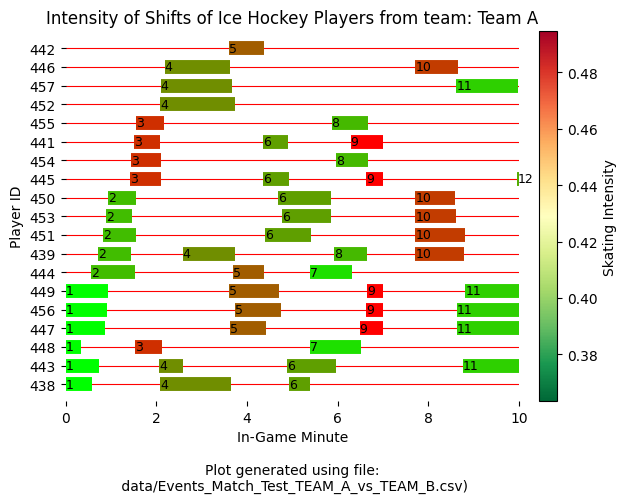

Shift Intensities using elbow method


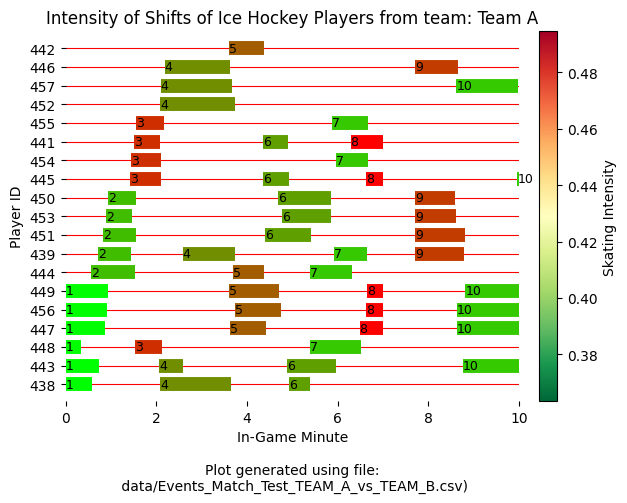

In [27]:
from utils import generate_block_config, plot_shifts_with_intensity

# Generieren der Block-Konfiguration für die Visualisierung
block_config = generate_block_config(
    naive=True,  # Oder False, je nach Analyse
    verbose=False,
    team_name="Team A",
    file_name_raw_data=file_name,
    file_name_save_plot=None  # Optional
)

# Erstellen der Visualisierung mit der naiven Methode
print("Shift Intensities using simple method")
df_teamA_intensities = plot_shifts_with_intensity(
    df_teamA, 
    block_config,
    time_window_start=0,  # Startzeit in Spielminuten
    time_window_duration=10,  # Dauer des zu visualisierenden Fensters in Minuten
    intensity_indicator="Skating Intensity"  # Die genaue Spalte in deinem df
)

# Zum Vergleich, die Shifts mit der elbow-method
print("Shift Intensities using elbow method")
block_config[utils.BLOCK_CONFIG_NOF_SHIFTS_DESCRIPTOR] = False
_ = plot_shifts_with_intensity(
    df_teamA, 
    block_config,
    time_window_start=0,  # Startzeit in Spielminuten
    time_window_duration=10,  # Dauer des zu visualisierenden Fensters in Minuten
    intensity_indicator="Skating Intensity"  # Die genaue Spalte in deinem df
)

#### Team B

Shift Intensities using simple method


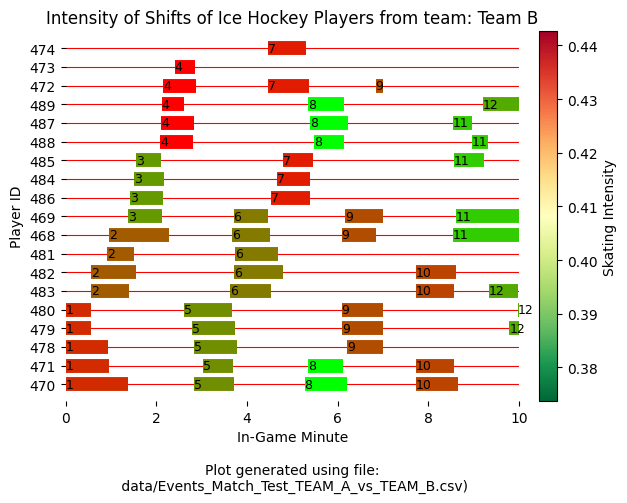

Shift Intensities using elbow method


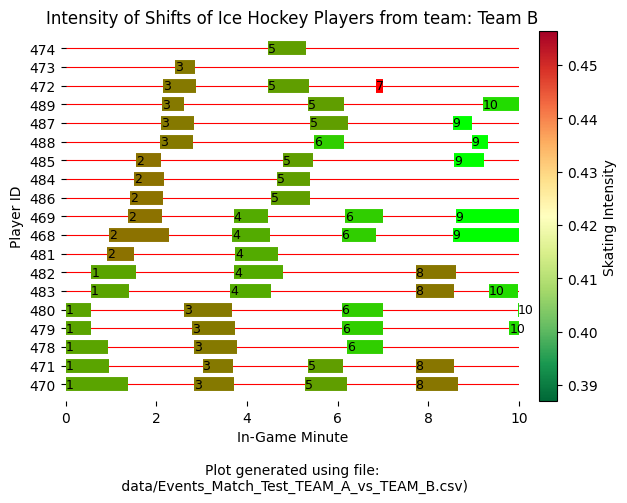

In [28]:
# Generieren der Block-Konfiguration für die Visualisierung
block_config = generate_block_config(
    naive=True,  # Oder False, je nach Analyse
    verbose=False,
    team_name="Team B",
    file_name_raw_data=file_name,
    file_name_save_plot=None  # Optional
)

# Erstellen der Visualisierung mit der naiven Methode
print("Shift Intensities using simple method")
df_teamB_intensities = plot_shifts_with_intensity(
    df_teamB, 
    block_config,
    time_window_start=0,  # Startzeit in Spielminuten
    time_window_duration=10,  # Dauer des zu visualisierenden Fensters in Minuten
    intensity_indicator="Skating Intensity"  # Die genaue Spalte in deinem df
)

# Zum Vergleich, die Shifts mit der elbow-method
print("Shift Intensities using elbow method")
block_config[utils.BLOCK_CONFIG_NOF_SHIFTS_DESCRIPTOR] = False
_ = plot_shifts_with_intensity(
    df_teamB, 
    block_config,
    time_window_start=0,  # Startzeit in Spielminuten
    time_window_duration=10,  # Dauer des zu visualisierenden Fensters in Minuten
    intensity_indicator="Skating Intensity"  # Die genaue Spalte in deinem df
)

#### SIS Team A vs. Team B